In [ ]:
'''
METODOLOGÍA

A Continuación, se presenta la metodología de evaluación comparativa de
tres modelos de clasificación para predecir la columna "not.fully.paid",
de acuerdo al dataset adquirido. Esta evaluación se llevará a cabo apli-
cando redes neuronales artificiales (ANN), redes neuronales para K medias
(KNN), y redes neuronales convolucionales (CNN).Se empieza con el respec-t
ivo setup e importanción de las librerías con sus debidos parámetros para
las gráficas a emplear en la primera celda, siendo la segunda y la tercera
de la obtención de los dataframes, incluyendo la codificación de cada pro-
pósito de préstamo, inlcuyendo el "home_improvement", el cual no se encon
traba en el documento guía. Seguidamente, en la cuarta celda se procede a
realizar un análisis estadístico del dataset.
'''
#Importar librerias

import pandas as pd
import neurolab as nl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from imblearn.over_sampling import SMOTE
import random

#Ajustar tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7]
#Desactivar Warnings de Referenciado en pandas
pd.options.mode.chained_assignment = None

In [ ]:
'''

'''

#Load CSV Data

with open(r"Data\Proy_Final_data.csv") as file:
    Data = pd.read_csv(file, sep= ",")

#Eliminar columna indice
Data = Data.drop({"Unnamed: 0"}, axis="columns")

print("-------------------------------")
print("Data Cargada: ")
print(Data.head(4))
print("-------------------------------")
print("Informacion del Dataset: ")
print(Data.info())
print("-------------------------------")

In [ ]:
#Codificacion de propositos
'''
    
'''
#Valores unicos de la columna de propositos
print("-------------------------------")
print("Valores unicos de la columna de propositos: ")
print(Data["purpose"].unique())
print("-------------------------------")

#Asignacion de valores numericos
Purposes = {
    "credit_card" : 0,
    "debt_consolidation" : 1,
    "educational" : 2,
    "major_purchase" : 3,
    "small_business" : 4,
    "all_other" : 5,
    "home_improvement" : 6
}

#Copia de dataset
CodedData = Data.copy()

#Asignacion de codigos a propositos
index = 0
for Purpose in Data["purpose"]:
    for UniquePurpose in Purposes:
        if UniquePurpose == Purpose:
            CodedData["purpose"][index] = Purposes[UniquePurpose] 
    index = index + 1

CodedData = CodedData.apply(pd.to_numeric)

#Dataset Codificado
print("-------------------------------")
print("Dataset Codificado: ")
print(CodedData.head())
print("-------------------------------")

In [ ]:
'''
-ANÁLISIS ESTADÍSTICO DEL DATASET
En esta sección, se busca conocer a profundidad el comportamiento
del dataset a través de métodos estocásticos. Pero se debe tener
en cuenta que como se aplicarán redes neuronales para todos los 
modelos, es necesario normalizar las variables de manera que cada
una de ellas sean comparables entre síPara ello, se realiza un 
estudio de correlación, que brinda la librería "Seaborn", de cada 
variable codificada en la celda anterior, de la cual se observa que...

'''
#Estadisticos del Dataset

#Correlacion entre variables
Correlation = CodedData.corr()
sns.heatmap(Correlation, annot=True)
plt.title("Matriz de Correlaciones")
plt.figure(1)
plt.show()

#Grafico de distribucion del dataset
sns.barplot(x = (CodedData["not.fully.paid"].unique()), 
            y = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/CodedData.shape[0])
plt.title("Distribucion del Dataset en funcion del pago de deudas")
plt.figure(2)
plt.show()

In [ ]:
'''

'''
#Almacenado Dataset De prueba y  entrenamiento 

#Division de creditos aprobados y rechazados
RejectedDT = CodedData.loc[CodedData["not.fully.paid"] == 0].copy()
AProvedDT = CodedData.loc[CodedData["not.fully.paid"] == 1].copy()

NRejected = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[0]

#Seleccion de dataset de prueba balanceado (10% del dataset original)
AprovedTestDT = AProvedDT.sample(frac = 0.10, random_state = random.randrange(100,1000))
NAprovedTest = AprovedTestDT.shape[0]
RejectedTestDT = RejectedDT.sample(frac = NAprovedTest/NRejected, random_state = random.randrange(100,1000))
NRejectedTest = RejectedTestDT.shape[0]

#Dataset de entrenamiento
AprovedTrainDT = AProvedDT.drop(AprovedTestDT.index)
AprovedTrainDT = AprovedTrainDT.reset_index(drop = True)
RejectedTrainDT = RejectedDT.drop(RejectedTestDT.index)
RejectedTrainDT = RejectedTrainDT.reset_index(drop = True)

TrainDT = pd.concat([AprovedTrainDT, RejectedTrainDT], axis = 0, copy = True, ignore_index = True)
TrainDT = TrainDT.reset_index(drop = True)

In [ ]:
#Metodologia de Dataset Completo

#Normalizar el Dataset
NormalizedData = (TrainDT - TrainDT.min())/(TrainDT.max() -TrainDT.min())

In [ ]:
#Perceptron de unica capa
XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), 
                                                NormalizedData["not.fully.paid"],
                                                test_size = 0.3)

clf = Perceptron(tol=1e-6, random_state= random.randrange(1,9999), n_jobs = 4)
clf.fit(XTrain, YTrain)
YPredict = clf.predict(XTest)

#Curva ROC
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
RocCurve.plot()
plt.show()

pickle.dump(clf, open(r"OutPut\ANN\FullDataset\Network_Dataset_Completo", "wb"))

In [ ]:
#Clasificador KNN

XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), 
                                                NormalizedData["not.fully.paid"],
                                                test_size = 0.3)

K = 1
LastAccuracy = 0

KNNmodel = KNeighborsClassifier(n_neighbors=K)
KNNmodel.fit(XTrain, YTrain)
YPredict = KNNmodel.predict(XTest)
Accuracy = metrics.accuracy_score(YTest, YPredict)

AccuracyPlot = np.array(Accuracy)
KPlot = np.array(K)

while (Accuracy > LastAccuracy*0.95) and (round(Accuracy,5) != round(LastAccuracy,5)):
    K = K + 1
    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    LastAccuracy = Accuracy
    Accuracy = metrics.accuracy_score(YTest, YPredict)

    AccuracyPlot = np.append(AccuracyPlot, Accuracy)
    KPlot = np.append(KPlot, K)

#Curva Roc
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "KNN ROC")
RocCurve.plot()
plt.show()

#Curva Accuracy
plt.plot(KPlot, AccuracyPlot)
plt.title("Error Clasificador KNN")
plt.show()

pickle.dump(KNNmodel, open("OutPut\KNN\FullDataset\KNN_FullDataset", "wb"))

In [ ]:
#Clasificador Naive Bayes Gaussiano

XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), 
                                                NormalizedData["not.fully.paid"],
                                                test_size = 0.3)

BayesModel = GaussianNB()
BayesModel.fit(XTrain, YTrain)
YPredict = BayesModel.predict(XTest)

#Curva Roc
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()
pickle.dump(KNNmodel, open("OutPut\BAYES\FullDataset\Bayes_FullDataset", "wb"))

In [ ]:
#Metodologia de Balanceo por submuestreo de la clase mayoritaria

NAproved = TrainDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[1]
NRejected = TrainDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[0]
NSubsamples = (NRejected/NAproved)
print("Cantidades de creditos aprobados")
print(NAproved)
print("Candidades de creditos rechazados")
print(NRejected)
print("Numero de submuestras")
print(NSubsamples)

RejectedDT = NormalizedData.loc[NormalizedData["not.fully.paid"] == 0].copy()
AProvedDT = NormalizedData.loc[NormalizedData["not.fully.paid"] == 1].copy()

Subsamples = list()
for i in range(int(NSubsamples)):
    Subsample = RejectedDT.sample(frac = 1/(NSubsamples - i), random_state = random.randrange(100,1000))
    RejectedDT = RejectedDT.drop(Subsample.index)
    Subsample = pd.concat([Subsample, AProvedDT])
    Subsample = Subsample.reset_index(drop = True)
    Subsamples.append(Subsample)

print("Submuestras: ")
z = 0
for Subsample in Subsamples:
    print(Subsample.shape)
    sns.barplot(x = (Subsample["not.fully.paid"].unique()), 
            y = Subsample.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/Subsample.shape[0])
    plt.title("Distribucion del Subsample N°" + str(z) + " en funcion del pago de deudas")
    plt.figure(2)
    plt.show()
    z = z + 1

In [ ]:
#Perceptron de unica capa

z = 0
clf_list = list()
accuracy_list = list()

for Subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), 
                                                Subsample["not.fully.paid"],
                                                test_size = 0.3)

    clf = Perceptron(tol=1e-6, random_state= random.randrange(1,9999), n_jobs = 4)
    clf.fit(XTrain, YTrain)
    YPredict = clf.predict(XTest)
    
    #Accuracy
    accuracy_list.append(metrics.accuracy_score(YTest, YPredict))
    clf_list.append(clf)

    #Curva ROC
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
    RocCurve.plot()
    plt.show()

    z = z + 1

pickle.dump(clf_list[accuracy_list.index(max(accuracy_list))], open(r"OutPut\ANN\Subsample\Network_Subsample_equal", "wb"))

In [ ]:
#Clasificador KNN

z = 0
KNN_list = list()
accuracy_list = list()

for subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), Subsample["not.fully.paid"],test_size = 0.3)

    
    K = 1
    LastAccuracy = 0
    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    Accuracy = metrics.accuracy_score(YTest, YPredict)

    AccuracyPlot = np.array(Accuracy)
    KPlot = np.array(K)

    while (Accuracy > LastAccuracy*0.90) and (round(Accuracy,5) != round(LastAccuracy,5)):
        K = K + 1
        KNNmodel = KNeighborsClassifier(n_neighbors=K)
        KNNmodel.fit(XTrain, YTrain)
        YPredict = KNNmodel.predict(XTest)
        LastAccuracy = Accuracy
        Accuracy = metrics.accuracy_score(YTest, YPredict)

        AccuracyPlot = np.append(AccuracyPlot, Accuracy)
        KPlot = np.append(KPlot, K)
    
    KNN_list.append(KNNmodel)
    accuracy_list.append(Accuracy)
    
    plt.plot(KPlot, AccuracyPlot)
    plt.title("Error Clasificador KNN (Dataset Subsampleado N°"+str(z)+")")
    plt.figure(4)
    plt.show()
    
    Error = pd.DataFrame(YTest - YPredict)
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "KNN ROC")
    RocCurve.plot()
    plt.show()

    z = z + 1

pickle.dump(KNN_list[accuracy_list.index(max(accuracy_list))], open(r"OutPut\KNN\Subsample\KNN_Subsample", "wb"))

In [ ]:
#Clasificador Naive Bayes Gaussiano

z = 0
Bayes_list = list()
accuracy_list = list()

for subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), 
                                                    NormalizedData["not.fully.paid"],
                                                    test_size = 0.3)

    BayesModel = GaussianNB()
    BayesModel.fit(XTrain, YTrain)
    YPredict = BayesModel.predict(XTest)

    accuracy_list.append(metrics.accuracy_score(YTest, YPredict))
    Bayes_list.append(BayesModel)

    #Curva Roc
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
    RocCurve.plot()
    plt.show()

    z = z + 1
    
pickle.dump(Bayes_list[accuracy_list.index(max(accuracy_list))], open("OutPut\BAYES\Subsample\Bayes_Subsample", "wb"))

In [ ]:
#Ensemble con submuestreo

In [ ]:
#Perceptron de unica capa

z = 0

for Subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), 
                                                Subsample["not.fully.paid"],
                                                test_size = 0.3)

    clf = Perceptron(tol=1e-6, random_state= random.randrange(1,9999), n_jobs = 4)
    clf.fit(XTrain, YTrain)
    YPredict = clf.predict(XTest)
    
    #Accuracy
    accuracy_list.append(metrics.accuracy_score(YTest, YPredict))

    #Curva ROC
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
    RocCurve.plot()
    plt.show()

    pickle.dump(clf, open(r"OutPut\ANN\Ensemble\Network_Ensemble_N" + str(z), "wb"))

    z = z + 1


In [ ]:
#Clasificador KNN

z = 0
for subsample in Subsamples:

    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), Subsample["not.fully.paid"],test_size = 0.3)

    K = 1
    LastAccuracy = 0

    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    Accuracy = metrics.accuracy_score(YTest, YPredict)

    AccuracyPlot = np.array(Accuracy)
    KPlot = np.array(K)

    while (Accuracy > LastAccuracy*0.95) and (round(Accuracy,5) != round(LastAccuracy,5)):
        K = K + 1
        KNNmodel = KNeighborsClassifier(n_neighbors=K)
        KNNmodel.fit(XTrain, YTrain)
        YPredict = KNNmodel.predict(XTest)
        LastAccuracy = Accuracy
        Accuracy = metrics.accuracy_score(YTest, YPredict)

        AccuracyPlot = np.append(AccuracyPlot, Accuracy)
        KPlot = np.append(KPlot, K)

    plt.plot(KPlot, AccuracyPlot)
    plt.title("Error Clasificador KNN (Dataset Subsampleado N°"+str(z)+")")
    plt.figure(4)
    plt.show()

    #Curva ROC
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
    RocCurve.plot()
    plt.show()
    
    pickle.dump(KNNmodel, open(r"OutPut\KNN\Ensemble\KNN_Ensemble_N" + str(z), "wb"))
    z = z + 1

In [ ]:
#Clasificador Naive Bayes Gaussiano

z = 0
for subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(subsample.drop(["not.fully.paid"], axis = 1), 
                                                    subsample["not.fully.paid"],
                                                    test_size = 0.3)

    BayesModel = GaussianNB()
    BayesModel.fit(XTrain, YTrain)
    YPredict = BayesModel.predict(XTest)

    #Curva Roc
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
    RocCurve.plot()
    plt.show()

    pickle.dump(BayesModel, open(r"OutPut\BAYES\Ensemble\Bayes_Ensemble_N" + str(z), "wb"))

    z = z + 1

Oversampled Input Dataframe: 
   credit.policy   purpose  int.rate  installment  log.annual.inc       dti  \
0            0.0  0.833333  0.107417     0.421658        0.456793  0.789052   
1            1.0  1.000000  0.372762     0.879077        0.690924  0.083778   
2            1.0  1.000000  0.417519     0.229223        0.506334  0.136849   
3            0.0  0.833333  0.543478     0.057525        0.512797  0.806409   
4            0.0  1.000000  0.639386     0.165598        0.494868  0.460614   

       fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  0.465116           0.175307   0.048864    0.468067        0.090909   
1  0.883721           0.286985   0.001714    0.033613        0.030303   
2  0.627907           0.149533   0.000128    0.010084        0.181818   
3  0.232558           0.297293   0.008695    0.840336        0.030303   
4  0.255814           0.195925   0.008085    0.455462        0.181818   

   delinq.2yrs  pub.rec  
0          0.0      0.0  
1   

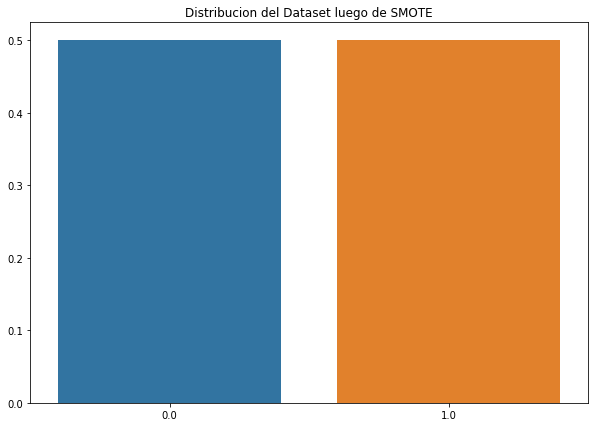

<Figure size 720x504 with 0 Axes>

In [97]:
#Metodologia SMOTE
SM = SMOTE(sampling_strategy = 1.0, random_state = random.randrange(200,1000), k_neighbors = 5, n_jobs = 2)

SMDT = NormalizedData.copy()
InputDT, TargetDT = SM.fit_resample(SMDT.drop(["not.fully.paid"], axis = 1), SMDT["not.fully.paid"])
TargetDT = TargetDT.to_frame()
print("Oversampled Input Dataframe: ")
print(InputDT.head())
print("Oversampled Target Dataframe: ")
print(TargetDT.head())

sns.barplot(x = (TargetDT["not.fully.paid"].unique()), 
            y = TargetDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/TargetDT.shape[0])
plt.title("Distribucion del Dataset luego de SMOTE")
plt.figure(2)
plt.show()

C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


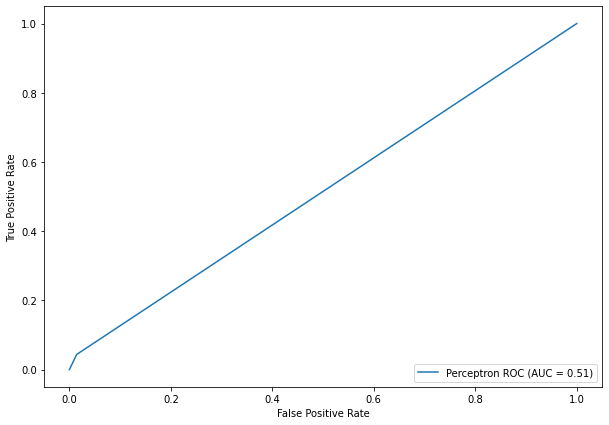

In [98]:
#Red Neuronal

XTrain, XTest, YTrain, YTest = train_test_split(InputDT, TargetDT, test_size = 0.3)

clf = Perceptron(tol=1e-6, random_state= random.randrange(1,9999), n_jobs = 4)
clf.fit(XTrain, YTrain)
YPredict = clf.predict(XTest)

#Curva ROC
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
RocCurve.plot()
plt.show()

pickle.dump(clf, open(r"OutPut\ANN\SMOTE\Network_Dataset_SMOTE", "wb"))

C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K = 1, Accuracy: 0.8524223602484472


C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Last Accuracy: 0.8524223602484472
K = 2, Accuracy: 0.8650931677018634


C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Last Accuracy: 0.8650931677018634
K = 3, Accuracy: 0.8111801242236025


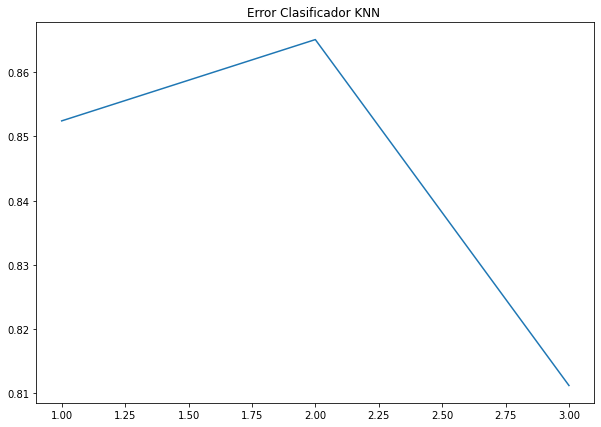

<Figure size 720x504 with 0 Axes>

In [99]:
#Clasificador KNN

XTrain, XTest, YTrain, YTest = train_test_split(InputDT, TargetDT, test_size = 0.3)

K = 1
LastAccuracy = 0

KNNmodel = KNeighborsClassifier(n_neighbors=K)
KNNmodel.fit(XTrain, YTrain)
YPredict = KNNmodel.predict(XTest)
Accuracy = metrics.accuracy_score(YTest, YPredict)
print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

AccuracyPlot = np.array(Accuracy)
KPlot = np.array(K)

while (Accuracy > LastAccuracy*0.95) and (round(Accuracy,5) != round(LastAccuracy,5)):
    K = K + 1
    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    LastAccuracy = Accuracy
    Accuracy = metrics.accuracy_score(YTest, YPredict)
    print("Last Accuracy: " + str(LastAccuracy))
    print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

    AccuracyPlot = np.append(AccuracyPlot, Accuracy)
    KPlot = np.append(KPlot, K)

pickle.dump(KNNmodel, open(r"OutPut\KNN\SMOTE\KNN_SMOTE", "wb"))
plt.plot(KPlot, AccuracyPlot)
plt.title("Error Clasificador KNN ")
plt.figure(4)
plt.show()

C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


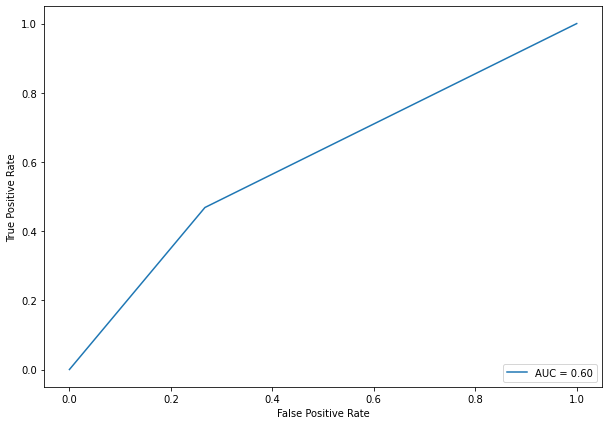

In [100]:
#Clasificador bayesiano

XTrain, XTest, YTrain, YTest = train_test_split(InputDT, TargetDT, test_size = 0.3)

BayesModel = GaussianNB()
BayesModel.fit(XTrain, YTrain)
YPredict = BayesModel.predict(XTest)

#Curva Roc
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

pickle.dump(BayesModel, open(r"OutPut\BAYES\SMOTE\KNN_SMOTE", "wb"))